In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

We will use mixure of Gaussians from sklearn

In [2]:
from sklearn.mixture import GaussianMixture

We will develop code for PCA (PCA2 in HW3, Q4) ourselves, using numpy and scipy  
More instructions below on where PCA2 will be used  
Also see HW3 Q4 for guidelines

In [3]:
from sklearn.decomposition import PCA

Loading the digits dataset

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()

Plotting the first 100 digits in a 10 x 10 grid  
This is just to remind ourselves what the data looks like

In [5]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

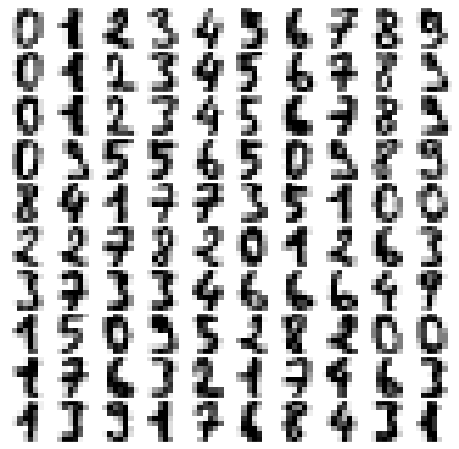

In [6]:
plot_digits(digits.data)

We are using sklearn's PCA here, these will be replaced by your code for PCA2 (HW3, Q4)  
We are creating a low-dimensional projection so that 90% of the variance is preserved after projection  
The exact dimensionality needed can be determined using the eigen-values of the covariance matrix of the data  
For preserving 90% of the variance, we need 21 dimensions, original data had 64 dimensions! 

In [7]:
pca90 = PCA(0.90, whiten=True)
data90 = pca90.fit_transform(digits.data)
data90.shape

(1797, 21)

Dim to preserve 0.9 variance = 21 ; Actual Variance at this threshold: 0.9031985012037209
newEVectors.shape: (64, 21)
Given inputData.shape: (1797, 64)
transformedData.shape: (1797, 21)


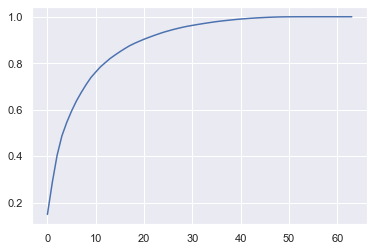

In [8]:
#myPCA
import pandas as pd
from numpy import linalg as la

class myPCA:
    smallD =0
    newEValues = np.empty([])
    newEVectors= np.empty([])
    newVar = np.empty([])
    
    def __init__(self):
        self.smallD =0
        self.newEValues = np.empty([])
        self.newEVectors= np.empty([])
        self.newVar = np.empty([])

    def getSmallDimSpace(self, var, thresholdVariance):
        ev = la.eig(var)
        eValues = ev[0]  # eigen values of Covariance Matrix sorted in descending order
        eVectors = ev[1] # Eigen Vectors of covariance Matrix
        
        ##sort the eigen values and eigen vectors correspondingly
        idx = eValues.argsort()[::-1]   
        eValues = eValues[idx]
        eVectors = eVectors[:,idx]
        
        #Calculate dimensions that are required to preserve the threshold variance given
        cumSum = 0
        sum = np.sum(eValues)
        cumVarianceRatio = np.zeros(eValues.shape[0])
        for i in range(eValues.shape[0]):
            cumSum = cumSum + eValues[i]
            cumVarianceRatio[i] = (cumSum / sum)
            if(cumVarianceRatio[i]>= thresholdVariance and self.smallD == 0 ):
                self.smallD = i+1 # since i starts from 0, actual dims = i+1
                print('Dim to preserve',thresholdVariance,'variance =', i+1, '; Actual Variance at this threshold:', cumVarianceRatio[i] )
                
        plt.plot(cumVarianceRatio)
        self.newEValues = eValues[0:self.smallD] # splice from 0, frst smallD elements
        self.newEVectors = eVectors[:,0:self.smallD]
        
    def inverseTransform(self, transformedData, mean):

        dotP = np.dot(transformedData, self.newEVectors.T)
        for i in range(transformedData.shape[0]):
            dotP[i] = dotP[i]+ np.array(mean).T
        return dotP
        
    def fit_transform(self, inputData, thresholdVariance):

        df = pd.DataFrame(data = inputData)
        mean1 = np.mean(df, axis = 0) # find column wise mean
        diff = np.subtract(df, mean1)

        #Compute Covarinace Matrix of data before projection
        S = np.dot(diff.T, diff)
        S = np.divide(S, diff.shape[0])
        self.getSmallDimSpace(S, thresholdVariance)

        #tranform data 
        print('newEVectors.shape:', self.newEVectors.shape) # (21, 64)
        print('Given inputData.shape:', inputData.shape) # (1797, 64)

        transformedData = np.dot(diff.values, self.newEVectors)
        print('transformedData.shape:', transformedData.shape) # (1797, 21)
        return transformedData, mean1, self.smallD

#Get small D data
myPCAObj = myPCA()
data90, mean, smallD = myPCAObj.fit_transform(digits.data, 0.90)


Next we fit a mixture of Gaussians on the projected data  
The first step is to figure how many components to use  
We use a model selection criterion called AIC, we have not discussed this in class  
Just use this bit as is

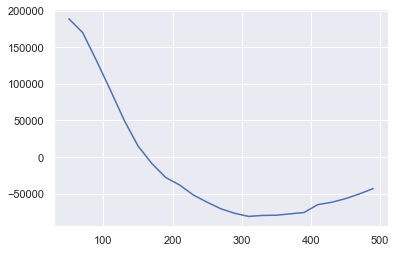

In [9]:
n_components = np.arange(50, 510, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data90).aic(data90) for model in models]
plt.plot(n_components, aics);

Looks like 250 components would suffice  
So we will fit a mixture of 250 Gaussians to the projected data  
Note that we are doing the fit in a 21 dimensional space

In [10]:
gmm90 = GaussianMixture(250, covariance_type='full', random_state=0)
gmm90.fit(data90)
print(gmm90.converged_)

True


Now, we will sample 100 samples from the learned mixture of 250 Gaussians  
Each sample will be a point in the 21 dimensional (projected) space  

In [11]:
data_new90 = gmm90.sample(100)[0]
data_new90.shape

(100, 21)

Finally, we will transform these 100 points in 21 dimensions back to the original 64 dimensional space  
We can then visualize them, and see if they look like digits from the digits dataset

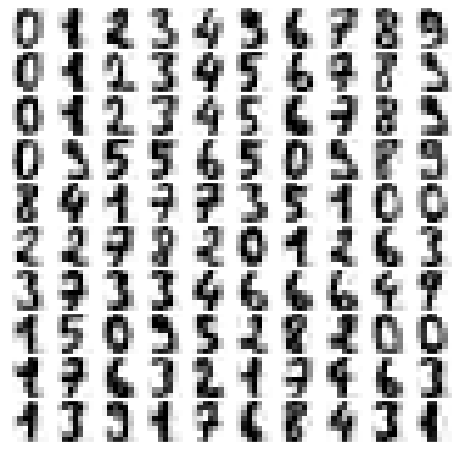

In [12]:
#digits_new90 = pca90.inverse_transform(data_new90)
digits_new90 = myPCAObj.inverseTransform(data90, mean)
plot_digits(digits_new90)


We will repeat the same exercise but by preserving 99% of the variance in the projected space  
We will need 41 (instead of 21) dimensions to preserve 99% (instead of 90%) of the variance  

Dim to preserve 0.99 variance = 41 ; Actual Variance at this threshold: 0.990101824279554
newEVectors.shape: (64, 41)
Given inputData.shape: (1797, 64)
transformedData.shape: (1797, 41)


(1797, 41)

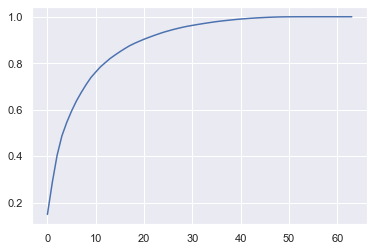

In [13]:
#pca99 = PCA(0.99, whiten=True)
#data99 = pca99.fit_transform(digits.data)
myPCA99 = myPCA()
data99, mean99, smallD99 = myPCA99.fit_transform(digits.data, 0.99)
data99.shape

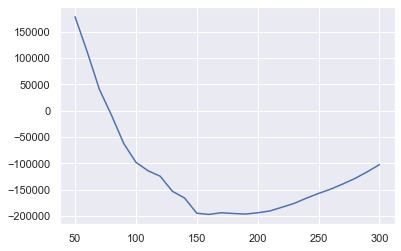

In [14]:
n_components = np.arange(50, 310, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data99).aic(data99) for model in models]
plt.plot(n_components, aics);

In [15]:
gmm99 = GaussianMixture(120, covariance_type='full', random_state=0)
gmm99.fit(data99)
print(gmm99.converged_)

True


In [16]:
data_new99 = gmm99.sample(100)[0]
data_new99.shape

(100, 41)

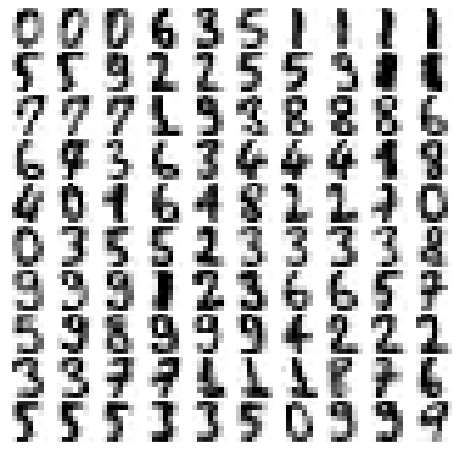

In [17]:
#digits_new99 = pca99.inverse_transform(data_new99)
digits_new99 = myPCA99.inverseTransform(data_new99, mean99)
plot_digits(digits_new99)